In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load the dataset

train_data = pd.read_csv('/content/drive/MyDrive/Online_Retail_Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Online_Retail_Test.csv')

### Data Pre-processing

In [ ]:
def preprocess_data(df):
    df = df.drop_duplicates()
    df = df[~df['InvoiceNo'].str.startswith(('C', 'A'))]
    df = df.dropna()
    irrelevant_stock_codes = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']
    df = df[~df['StockCode'].isin(irrelevant_stock_codes)]
    z_scores = (df[['UnitPrice', 'Quantity']] - df[['UnitPrice', 'Quantity']].mean()) / df[['UnitPrice', 'Quantity']].std()
    df = df[(z_scores.abs() < 3).all(axis=1)]
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
    return df

In [ ]:
preprocessed_train_data = preprocess_data(train_data)
preprocessed_train_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,1
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,6
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,0
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,2
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,3


In [ ]:
preprocessed_test_data = preprocess_data(test_data)
preprocessed_test_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-01-06 12:05:00,0.85,17315.0,United Kingdom,3
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,4
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,3
3,576652,22812,PACK 3 BOXES CHRISTMAS PANETTONE,3,2011-11-16 10:39:00,1.95,17198.0,United Kingdom,2
4,546157,22180,RETROSPOT LAMP,2,2011-10-03 08:40:00,9.95,13502.0,United Kingdom,0


### Understanding new insights from the data

In [ ]:
def analyze_data(df):

    # Find free items
    free_items = df[df['UnitPrice'] == 0]
    num_free_items = len(free_items)
    print(f"Number of free items: {num_free_items}")

    # Number of transactions per country
    transactions_per_country = df.groupby('Country').size().reset_index(name='TransactionCount')
    plt.figure(figsize=(15, 6))
    sns.barplot(x='Country', y='TransactionCount', data=transactions_per_country)
    plt.title('Number of Transactions per Country')
    plt.xticks(rotation=90)
    plt.ylabel('Number of Transactions')
    plt.show()

    # Ratio of repeat purchasers vs single-time purchasers
    repeat_customers = df.groupby('CustomerID').size()
    repeat_customers = len(repeat_customers[repeat_customers > 1])
    single_time_customers = len(df['CustomerID'].unique()) - repeat_customers
    repeat_ratio = repeat_customers / single_time_customers
    print(f"Ratio of repeat purchasers vs single-time purchasers: {repeat_ratio}")

    # Unit price heatmap
    df['Month'] = df['InvoiceDate'].dt.month_name()
    df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
    unit_price_heatmap = df.pivot_table(index='Month', columns='DayOfWeek', values='UnitPrice', aggfunc='mean')
    plt.figure(figsize=(10, 10))
    sns.heatmap(unit_price_heatmap, annot=True)
    plt.title('Unit Price per Month and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Month')
    plt.show()

    # Top 10 customers who bought the most number of items
    top_customers = df.groupby('CustomerID')['Quantity'].sum().nlargest(10)
    print(f"Top 10 customers who bought the most number of items:\n{top_customers}")

    # Top 10 items bought by the most number of customers
    top_items = df.groupby('StockCode')['CustomerID'].nunique().nlargest(10)
    print(f"Top 10 items bought by the most number of customers:\n{top_items}")

    # Create new features
    df['TotalAmountSpent'] = df['Quantity'] * df['UnitPrice']
    total_spent_per_customer = df.groupby('CustomerID')['TotalAmountSpent'].sum()
    print(f"Total amount spent per customer:\n{total_spent_per_customer}")

    return {
        'num_free_items': num_free_items,
        'transactions_per_country': transactions_per_country,
        'repeat_ratio': repeat_ratio,
        'unit_price_heatmap': unit_price_heatmap,
        'top_customers': top_customers,
        'total_spent_per_customer': total_spent_per_customer
    }

Number of free items: 30


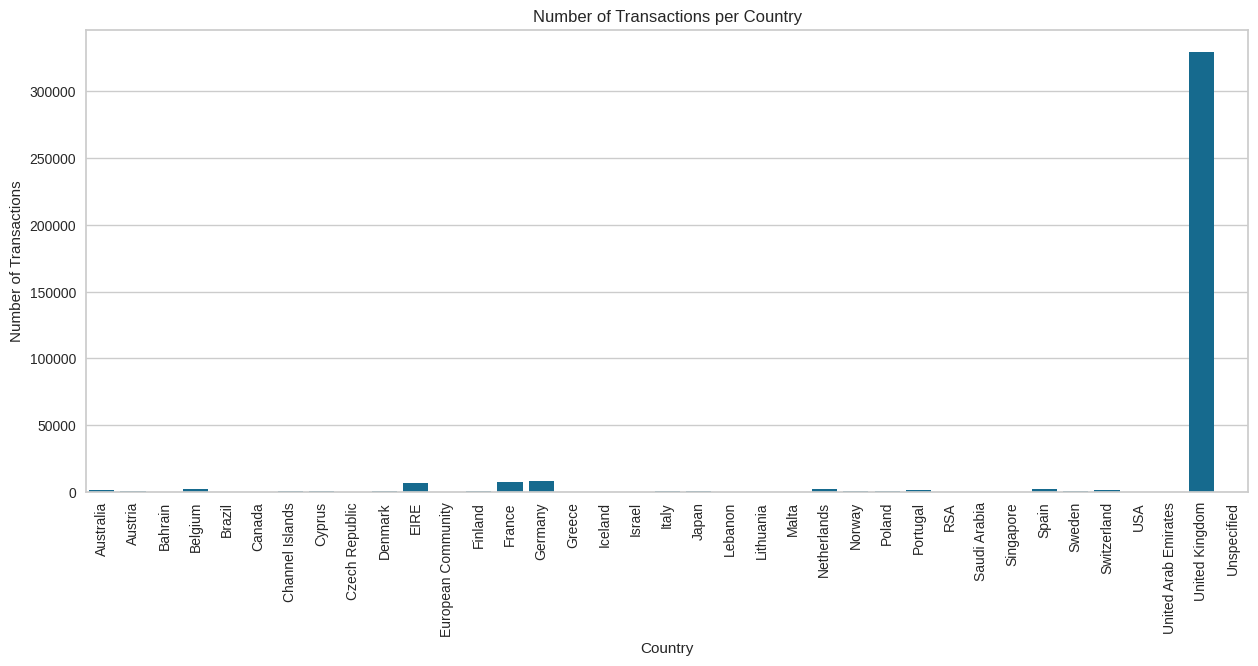

Ratio of repeat purchasers vs single-time purchasers: 59.732394366197184


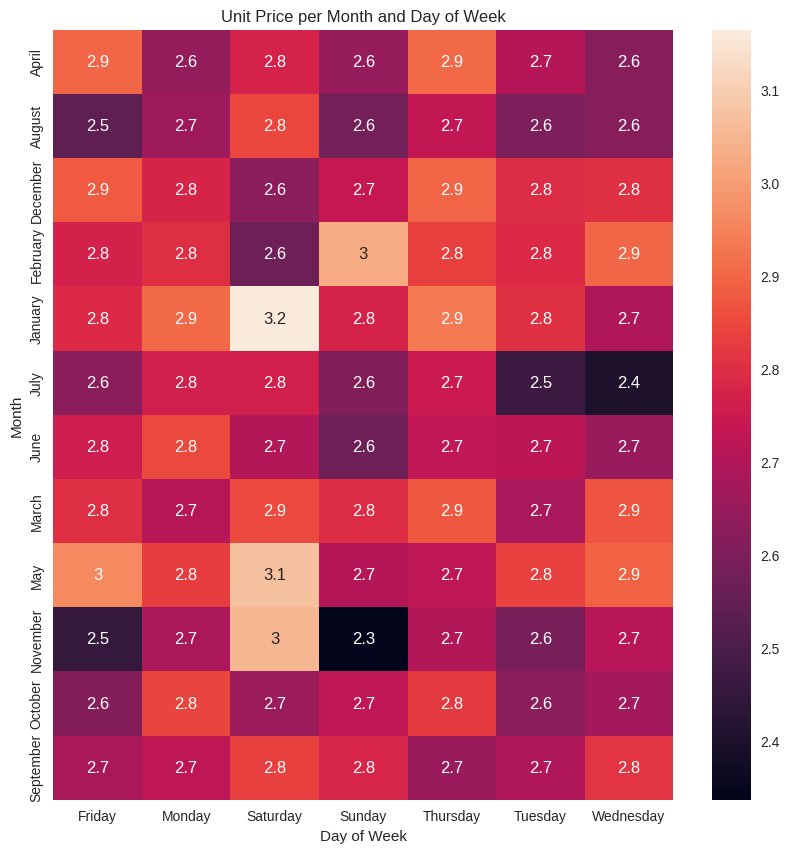

Top 10 customers who bought the most number of items:
CustomerID
14646.0    174245
14911.0     75157
12415.0     67764
17511.0     60128
18102.0     55687
13694.0     53908
14298.0     53777
14156.0     52024
16684.0     38185
17450.0     37375
Name: Quantity, dtype: int64
Top 10 items bought by the most number of customers:
StockCode
22423     851
85123A    825
47566     685
84879     652
22720     617
85099B    617
21212     615
22086     590
22457     567
22138     563
Name: CustomerID, dtype: int64
Total amount spent per customer:
CustomerID
12347.0    4091.80
12348.0    1395.48
12349.0    1241.26
12350.0     294.40
12352.0    1385.74
            ...   
18280.0     180.60
18281.0      46.92
18282.0     164.55
18283.0    1923.03
18287.0    1809.38
Name: TotalAmountSpent, Length: 4312, dtype: float64


In [ ]:
analysis_results_train = analyze_data(preprocessed_train_data)

Number of free items: 1


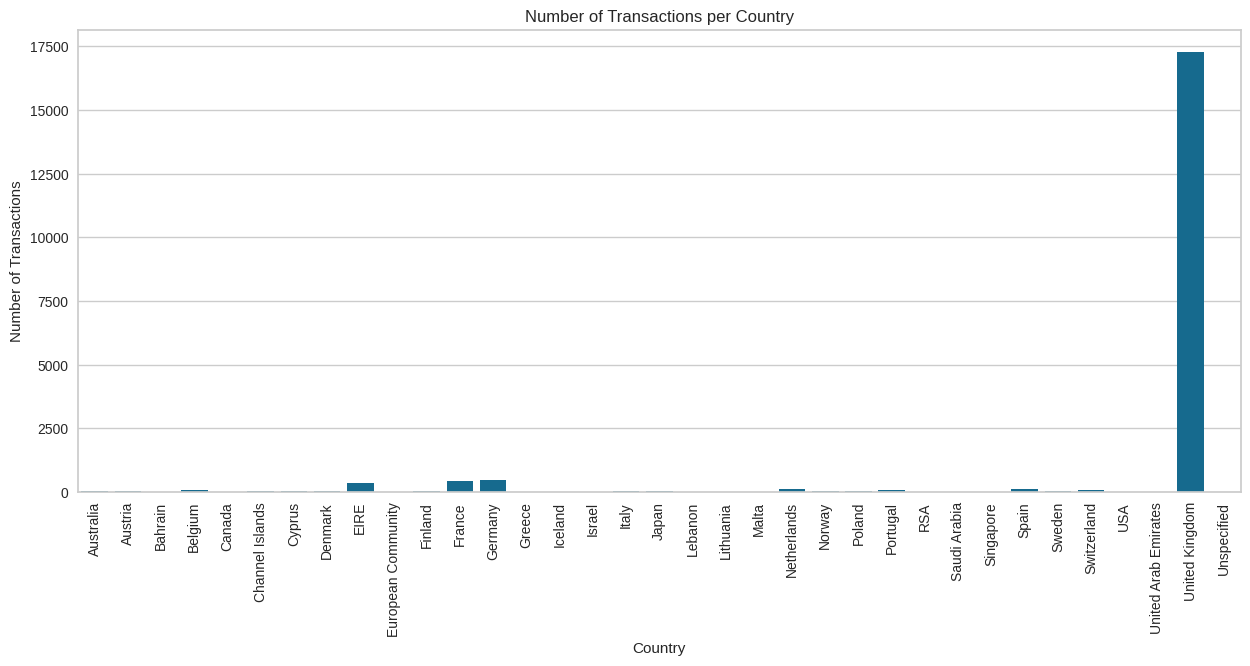

Ratio of repeat purchasers vs single-time purchasers: 3.1026282853566958


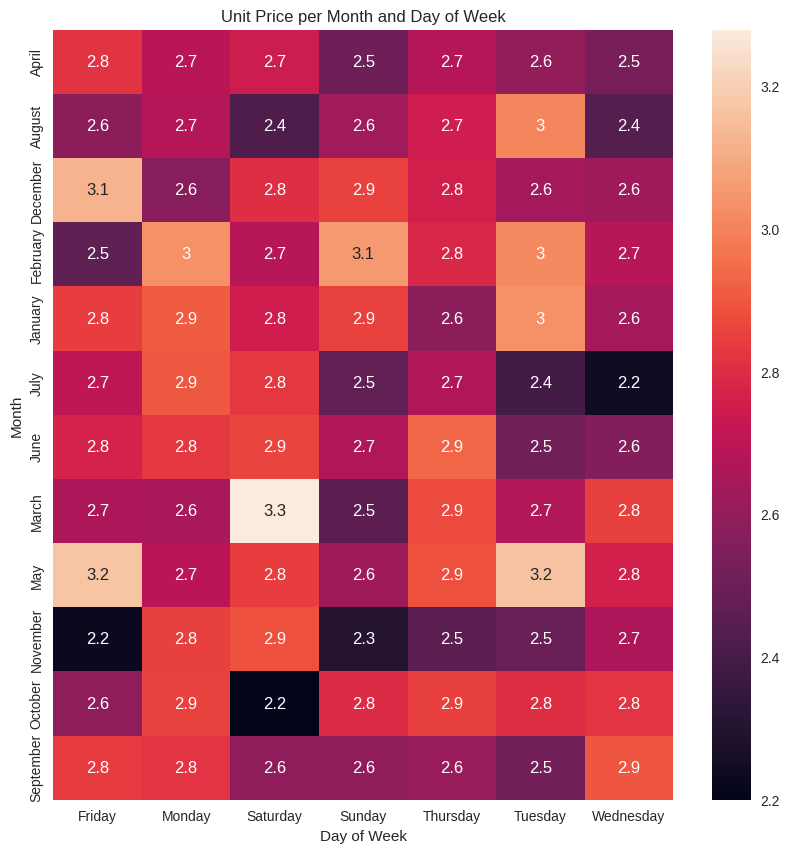

Top 10 customers who bought the most number of items:
CustomerID
14646.0    5195
14911.0    3731
14298.0    2735
15311.0    1820
17511.0    1410
13694.0    1384
12415.0    1353
14156.0    1250
13408.0    1169
12748.0    1146
Name: Quantity, dtype: int64
Top 10 items bought by the most number of customers:
StockCode
85123A    97
84879     76
85099B    76
22423     70
22086     59
47566     59
22382     58
23203     58
20728     55
22383     51
Name: CustomerID, dtype: int64
Total amount spent per customer:
CustomerID
12347.0    218.20
12349.0    112.54
12353.0     59.70
12354.0     24.40
12355.0    165.30
            ...  
18272.0    173.50
18276.0     23.40
18282.0     13.50
18283.0    109.26
18287.0     27.90
Name: TotalAmountSpent, Length: 3278, dtype: float64


In [ ]:
analysis_results_test = analyze_data(preprocessed_test_data)

In [ ]:
# Scale the train data
scaler = StandardScaler()

scaled_train_data = scaler.fit_transform(preprocessed_train_data[['Quantity', 'UnitPrice']])
scaled_train_df = pd.DataFrame(scaled_train_data, columns=['ScaledQuantity', 'ScaledUnitPrice'])
scaled_train_df

,ScaledQuantity,ScaledUnitPrice
0,-0.377812,2.265259
1,0.462044,-0.902954
2,-0.225111,-0.902954
3,-0.148760,-0.303033
4,-0.148760,-0.185401
...,...,...
369440,0.462044,-1.020586
369441,-0.377812,-0.420664
369442,-0.339636,-0.577507
369443,0.003941,0.089073


In [ ]:
# Scale the test data
scaled_test_data = scaler.fit_transform(preprocessed_test_data[['Quantity', 'UnitPrice']])
scaled_test_df = pd.DataFrame(scaled_test_data, columns=['ScaledQuantity', 'ScaledUnitPrice'])
scaled_test_df

,ScaledQuantity,ScaledUnitPrice
0,0.933311,-0.747800
1,-0.407813,1.706970
2,-0.407813,-0.828284
3,-0.474869,-0.305136
4,-0.541926,2.914233
...,...,...
19368,-0.005476,-0.425863
19369,0.128637,-0.244773
19370,0.933311,-0.586831
19371,0.933311,-0.868526


### Clustering

In [ ]:
# Implement K-means algorithm
def kmeans(data, n_clusters, max_iter=100):
    df = pd.DataFrame(data, columns=['Quantity', 'UnitPrice'])
    centroids = df.sample(n_clusters).values

    for _ in range(max_iter):
        clusters = np.argmin(np.linalg.norm(df.values[:, None] - centroids, axis=2), axis=1)
        new_centroids = np.array([df[clusters == i].mean(axis=0) for i in range(n_clusters)])

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids
    df['ClusterLabel'] = clusters
    return clusters, centroids

In [ ]:
# Implement DBSCAN algorithm
def dbscan(data, epsilon, min_points):
    clusters = np.zeros(len(data), dtype=int)
    cluster_num = 1

    for i, point in enumerate(data):
        if clusters[i] != 0:
            continue

        neighbors = np.linalg.norm(data - point, axis=1) < epsilon

        if sum(neighbors) < min_points:
            clusters[i] = -1
            continue

        clusters[i] = cluster_num
        expand_cluster(data, clusters, point, neighbors, cluster_num, epsilon, min_points)
        cluster_num += 1

    return clusters

In [ ]:
def expand_cluster(data, clusters, point, neighbors, cluster_num, epsilon, min_points):
    queue = np.where(neighbors)[0]

    while len(queue) > 0:
        current_point_index = queue[0]
        current_point = data[current_point_index]
        queue = np.delete(queue, 0)

        if clusters[current_point_index] == -1:
            clusters[current_point_index] = cluster_num

        if clusters[current_point_index] != 0:
            continue

        clusters[current_point_index] = cluster_num
        current_point_neighbors = np.linalg.norm(data - current_point, axis=1) < epsilon

        if sum(current_point_neighbors) >= min_points:
            queue = np.append(queue, np.where(current_point_neighbors)[0])

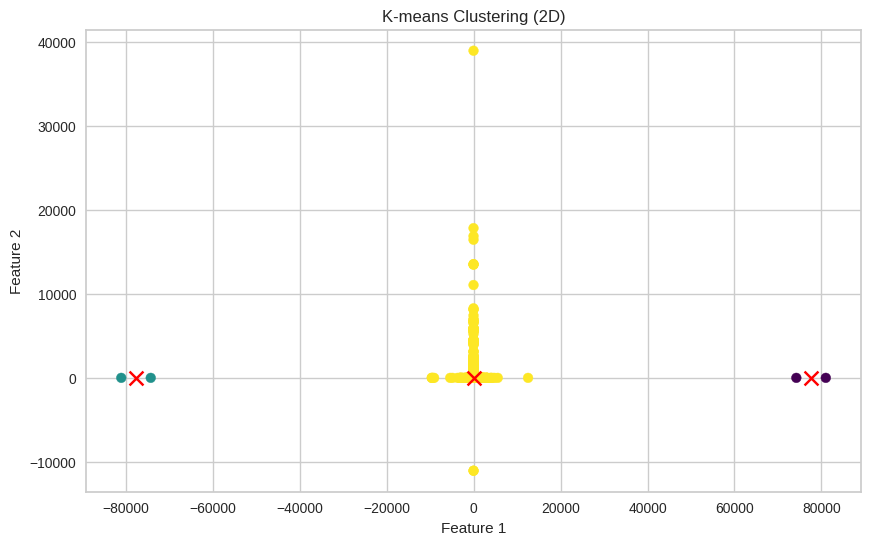

In [ ]:
# Visualize clusters (2D plot)
def plot_clusters_2d(data, clusters, centroids):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=100)
    plt.title('K-means Clustering (2D)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

clusters, centroids = kmeans(train_data[['Quantity', 'UnitPrice']].values, 3)
plot_clusters_2d(train_data[['Quantity', 'UnitPrice']].values, clusters, centroids)

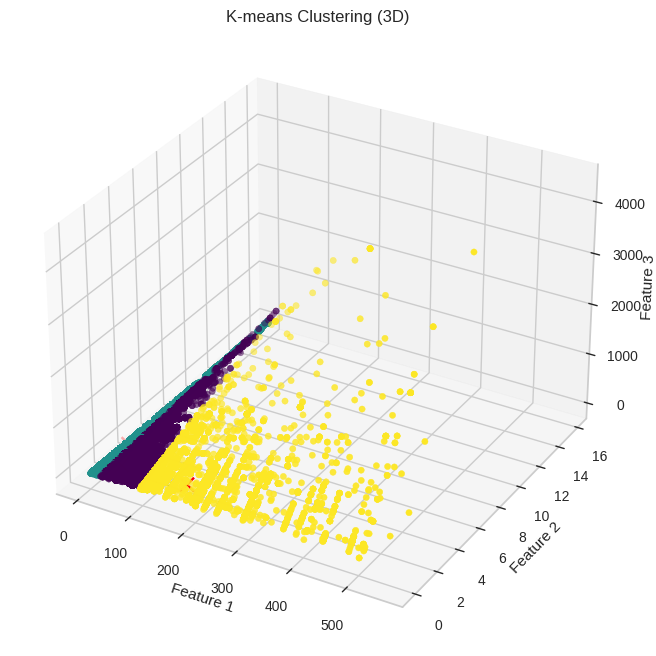

In [ ]:
# Visualize clusters (3D plot)
def plot_clusters_3d(data, clusters, centroids):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=clusters, cmap='viridis')
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=100)  # Removed [:, 2] from centroids
    ax.set_title('K-means Clustering (3D)')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.show()

# Find optimal K using the Elbow method
def find_optimal_k(data, max_k=10):
    ssd = []
    for k in range(1, max_k + 1):
        clusters, centroids = kmeans(data, k)
        ssd.append(np.sum((data - centroids[clusters]) ** 2))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), ssd, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Sum of Squared Distances (SSD)')
    plt.title('Elbow Method for Optimal K')
    plt.show()

# Apply K-means algorithm
k = 3
clusters, centroids = kmeans(preprocessed_train_data[['Quantity', 'UnitPrice', 'TotalAmountSpent']], k)

# Visualize clusters in 3D
plot_clusters_3d(preprocessed_train_data[['Quantity', 'UnitPrice', 'TotalAmountSpent']].values, clusters, centroids)

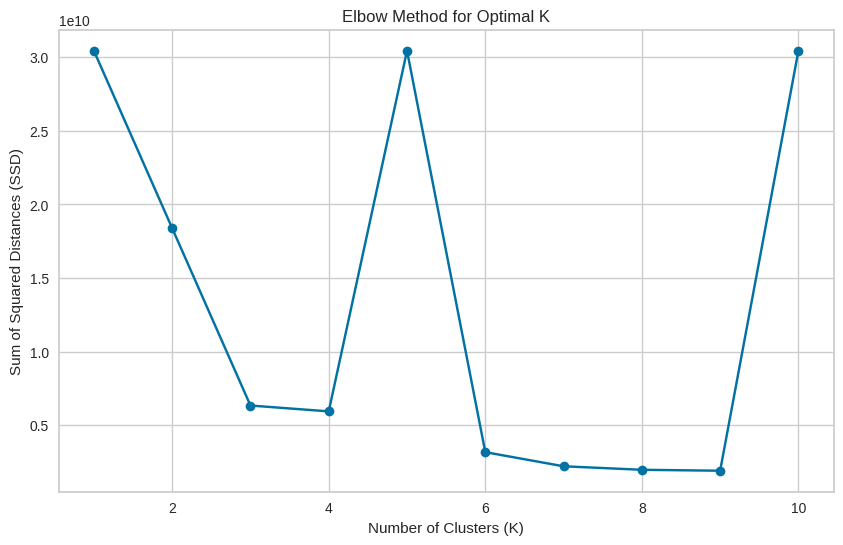

In [ ]:
find_optimal_k(train_data[['Quantity', 'UnitPrice']].values)

In [ ]:
# Create labeled data with k-means cluster labels
cluster_labels = clusters

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(preprocessed_train_data[['Quantity', 'UnitPrice', 'TotalAmountSpent']], cluster_labels, test_size=0.2, random_state=42)

# Scale the train and validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train a supervised algorithm on the scaled train data
model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
model.fit(X_train_scaled, y_train)

# Find the accuracy of the model using the scaled validation data
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 0.9998781956718862
